#### Jupyter Notebook to generate noisy images, segment, and evaluate error.


#### Imports

In [1]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
import matplotlib.pyplot as plt
from shutil import copy
from scipy.misc import imread, imsave

from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from AxonDeepSeg.testing.noise_simulation import *

%matplotlib inline

In [15]:
def classification_accuracy(prediction, groundtruth):
    """
    :param prediction: segmentation output from AxonDeepSeg
    :param groundtruth: 3-label mask (ground truth) of the sample
    :return: classification_accuracy (between 0 and 1)
    """

    # Get ground truth axon and myelin masks
    gt_axon = groundtruth[:,:,1] > 200
    gt_myelin = np.logical_and(groundtruth[:,:,1] >= 50, groundtruth[:,:,1] <= 200)

    # Get prediction axon and myelin masks
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)

    # Compute number of correctly classified pixels
    correctly_classified_myelins = np.logical_and(pred_myelin == 1, gt_myelin == 1).sum()
    correctly_classified_axons = np.logical_and(pred_axon == 1, gt_axon == 1).sum()
    correctly_classified_background = np.logical_and(prediction == 0, groundtruth[:,:,1] == 0).sum()

    correctly_classified = np.sum(correctly_classified_myelins+correctly_classified_axons+correctly_classified_background)
    nbr_pixels = prediction.size

    return np.true_divide(correctly_classified, nbr_pixels) 

#### Function definitions

#### Path to change (put path to image to segment)

In [16]:
path_img = '/Users/rudinakaprata/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/image.png'

#### Set paths for AxonDeepSeg segmentation tools

In [17]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask > 200
gt_axon = gt_axon[:,:,0]
gt_myelin = np.logical_and(mask >= 50, mask <= 200)
gt_myelin = gt_myelin[:,:,0]

In [42]:
import time


In [47]:
import tensorflow as tf
tf.reset_default_graph()

In [48]:
values = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
pw_accuracy_array = np.empty(0)
time_pred = np.empty(0)


for overlap_values in values:
    
    print(overlap_values)
    path_testing = path_folder
    
    start = time.time()
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,overlap_value=overlap_values,verbosity_level=0)
    end = time.time()
    time_pred_n = end-start
    time_pred = np.append(time_pred, [time_pred_n], axis=0)
    print(time_pred_n)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,'AxonDeepSeg.png'),flatten=True)
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    pw_accuracy = classification_accuracy(prediction,mask)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    pw_accuracy_array = np.append(pw_accuracy_array, [pw_accuracy], axis=0)

1
29.4333138466
2
28.1879501343
3
26.9825921059
4
26.8577330112
5
28.6015150547
10
26.5710229874
15
26.9522471428
20
28.5939490795
25
26.8645739555
30
26.8657300472
35
26.9184989929
40
26.6652350426
45
26.9744729996
50
26.3159019947
55
26.7490611076
60
30.0347819328
65
28.2881278992
70
32.6873629093
75
26.4394738674
80
28.0306658745
85
36.1421349049
90
27.6092720032
95
25.7584869862
100
27.8455569744


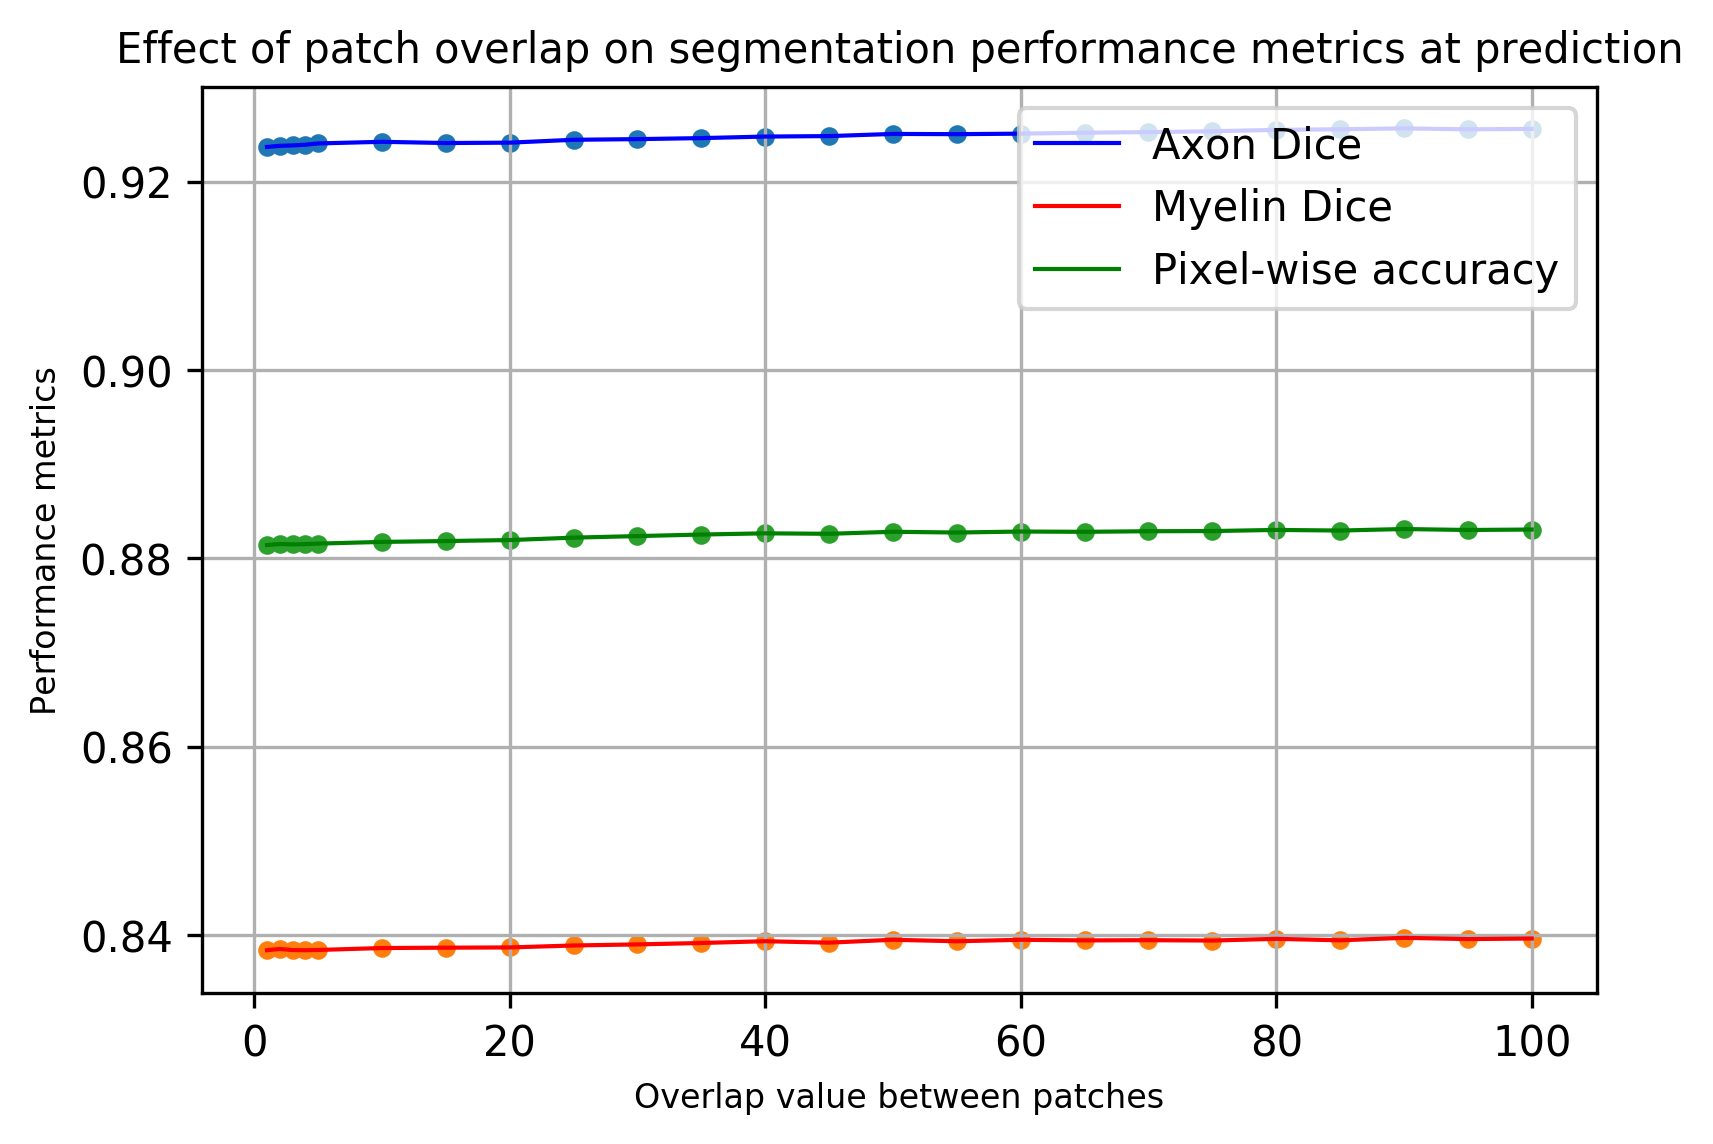

In [20]:

plt.figure(dpi=300)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.hold(True) 
plt.plot(values, pw_accuracy_array, 'g', lw=1)
plt.scatter(values, pw_accuracy_array, s=12)

plt.xlabel('Overlap value between patches',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of patch overlap on segmentation performance metrics at prediction',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice','Pixel-wise accuracy'])
#plt.xlim(0, 0.3)
plt.grid(True)

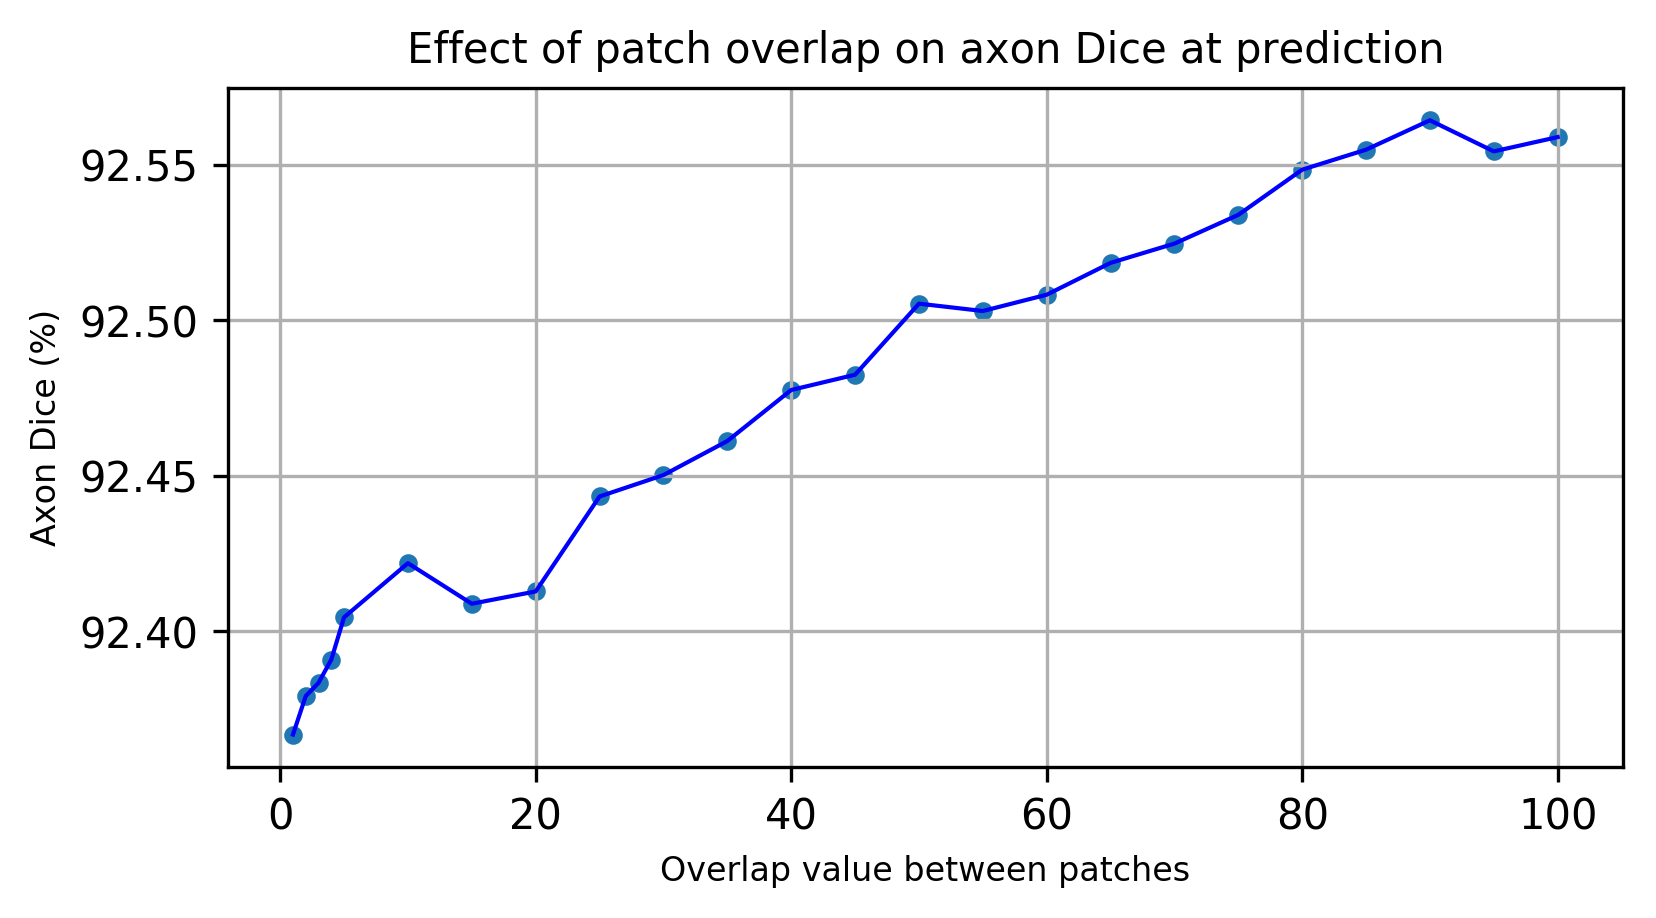

In [37]:
plt.figure(dpi=300,figsize=(6,3))
plt.plot(values, dice_axon_array*100, 'b', lw=1)
plt.scatter(values, dice_axon_array*100, s=12)

plt.xlabel('Overlap value between patches',fontsize=8)
plt.ylabel('Axon Dice (%)',fontsize=8)
plt.title('Effect of patch overlap on axon Dice at prediction',fontsize=10)
plt.grid(True)

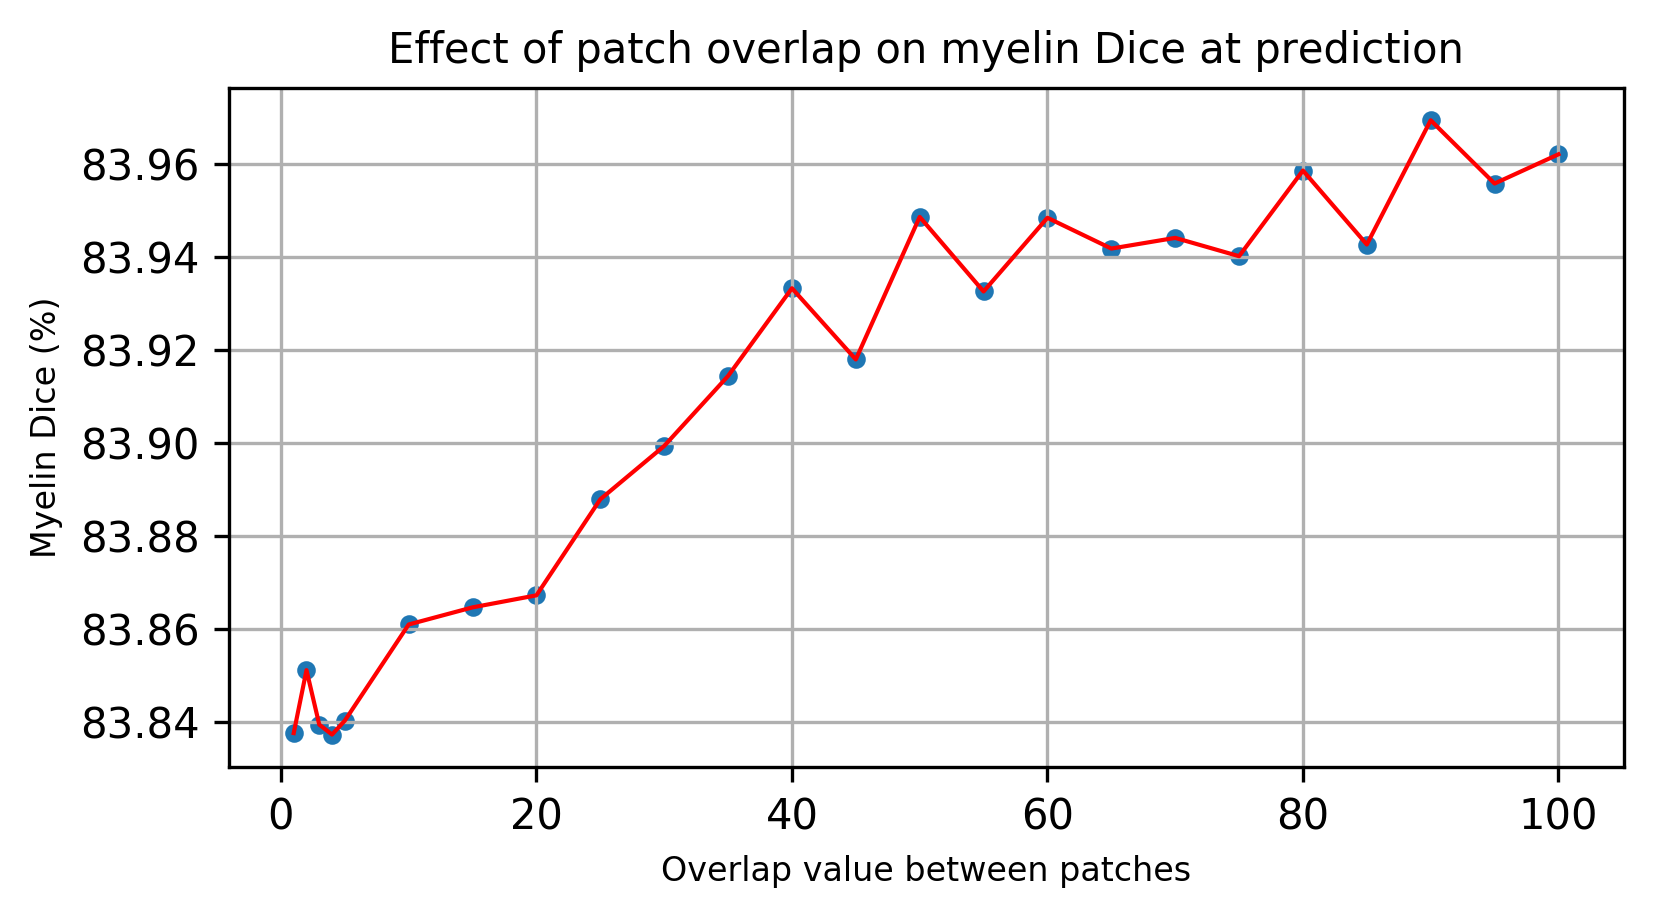

In [38]:
plt.figure(dpi=300,figsize=(6,3))
plt.plot(values, dice_myelin_array*100, 'r', lw=1)
plt.scatter(values, dice_myelin_array*100, s=12)

plt.xlabel('Overlap value between patches',fontsize=8)
plt.ylabel('Myelin Dice (%)',fontsize=8)
plt.title('Effect of patch overlap on myelin Dice at prediction',fontsize=10)
plt.grid(True)

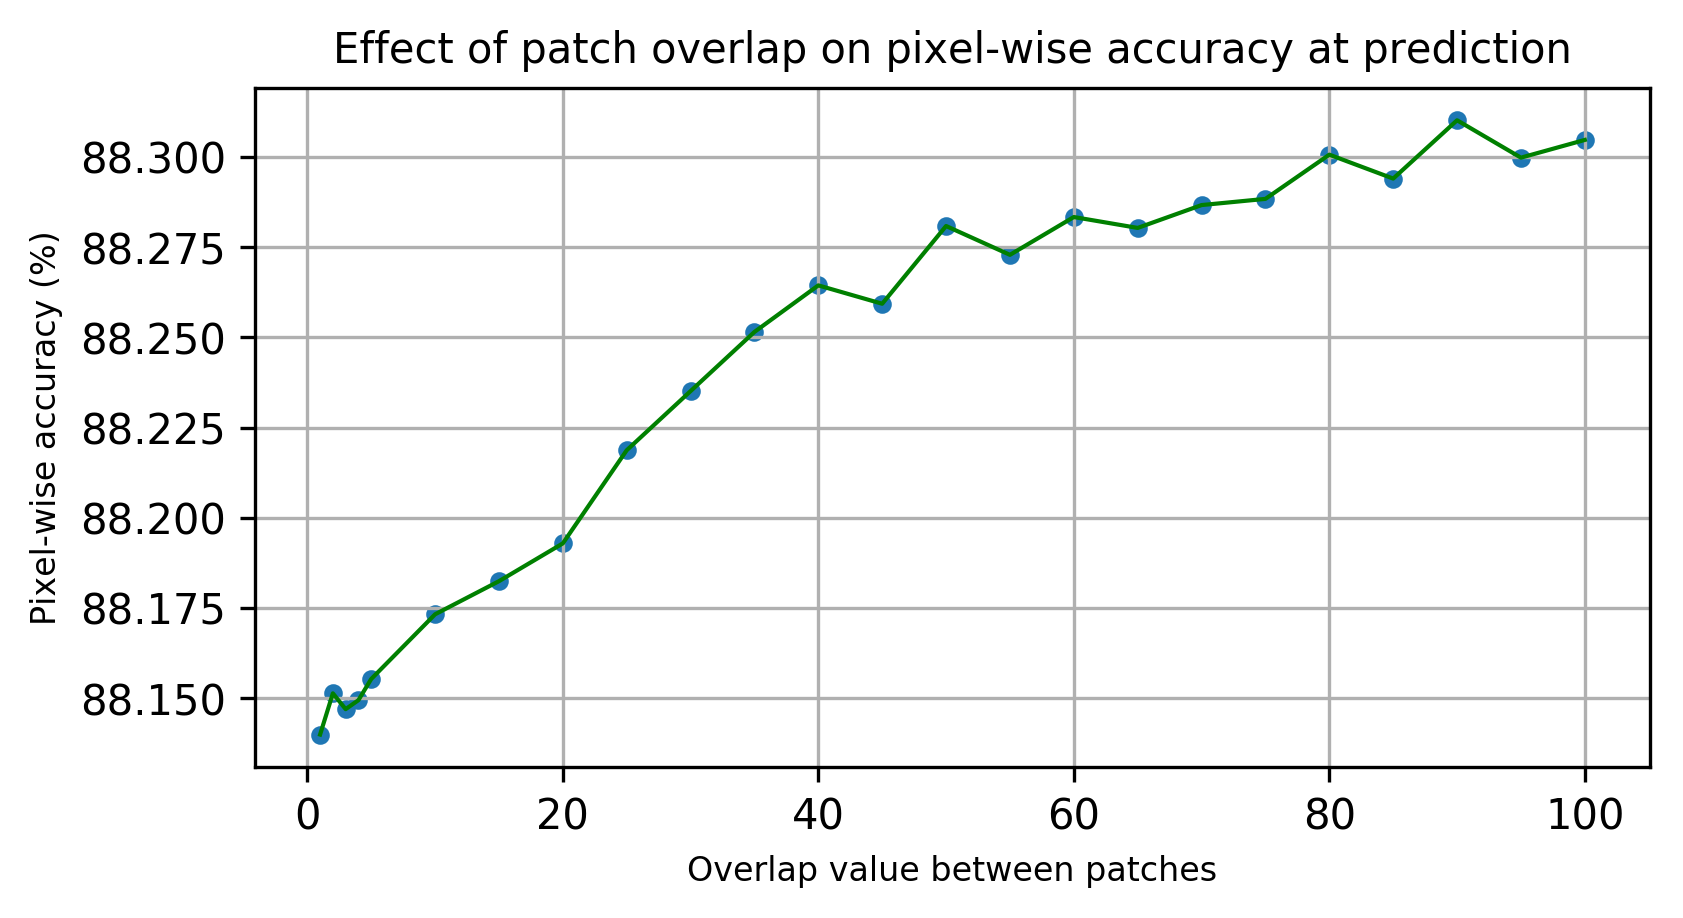

In [39]:
plt.figure(dpi=300,figsize=(6,3))
plt.plot(values, pw_accuracy_array*100, 'g', lw=1)
plt.scatter(values, pw_accuracy_array*100, s=12)

plt.xlabel('Overlap value between patches',fontsize=8)
plt.ylabel('Pixel-wise accuracy (%)',fontsize=8)
plt.title('Effect of patch overlap on pixel-wise accuracy at prediction',fontsize=10)
plt.grid(True)

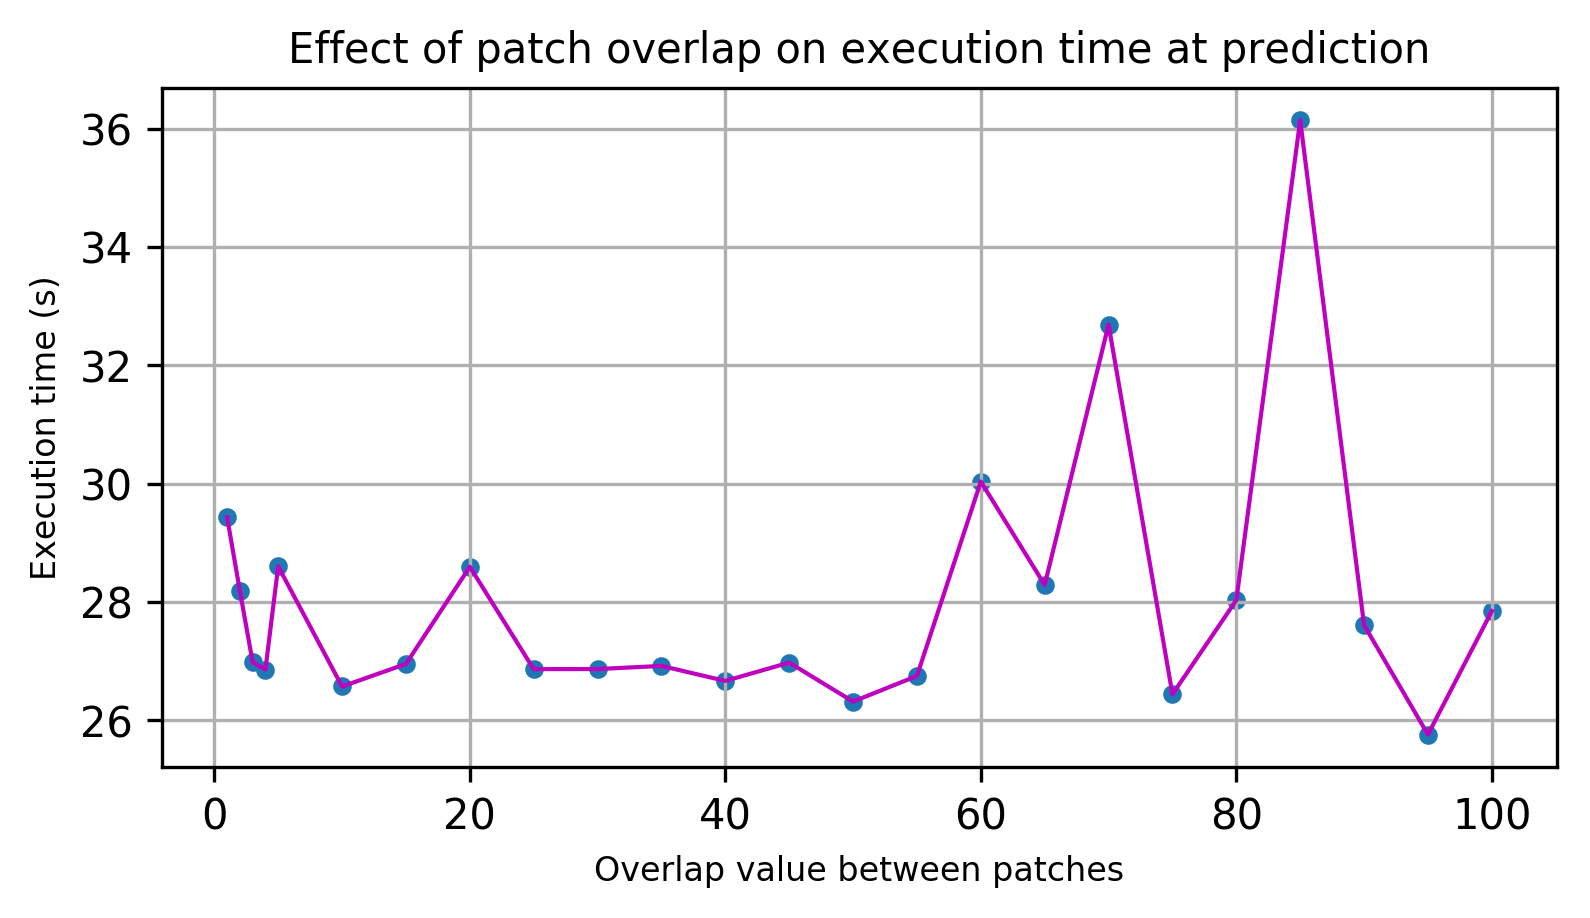

In [49]:
plt.figure(dpi=300,figsize=(6,3))
plt.plot(values, time_pred, 'm', lw=1)
plt.scatter(values, time_pred, s=12)

plt.xlabel('Overlap value between patches',fontsize=8)
plt.ylabel('Execution time (s)',fontsize=8)
plt.title('Effect of patch overlap on execution time at prediction',fontsize=10)
plt.grid(True)